# Week 4 - Regression and Model Evaluation

**Student Name 1, Student Name 2**

## Aims

By the end of this notebook you will be able to 

>* fit a linear regression
>* understand the basics of polynomial regression
>* understand how to evaluate and compare models and select tuning parameters with training, validation, and testing.

1. [Problem Definition and Setup](#setup)

2. [Exploratory Data Analysis](#EDA)

3. [Least Squares Estimation](#RBH)

4. [Regression using scikit-Learn](#RSKL)

5. [Polynomial Regression](#polyreg)

During workshops, you will complete the worksheets together in teams of 2-3, using **pair programming**. From this week onwards, the worksheets will no longer contain cues to switch roles between driver and navigator; this should occur approximately every 15 minutes and should be more natural after the first weeks. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given.

---

# Problem Definition and Setup <a id='setup'></a>

## Packages

First, let's load the packages you wil need for this workshop.

In [3]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules and some other will be added later
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

## User Defined Helper Functions

Below are two helper functions we will be using in this workshop. You can modify or create your own if you think it is useful or simply use already available functions within `sklearn`.  

- `model_fit()`: Returns the mean squared error, root mean squared error and R^2 value of a fitted model based  on the provided X and y values with plotting as add-on.
- `compute_std_error()`: Computes the standar error of the coefficients, with plotting as add-on.

In [4]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should residual plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Observed vs Fitted values")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted values vs Residuals")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsq) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [5]:
def compute_std_error(m, X, y, plot = False, feature_names = None, figsize = (5,5)):
    """Returns the standard errors of the model coefficients for a fitted linear model.
    
    Args:
        m: sklearn LinearRegression model object or pipeline with LinearRegression as final step
        X: training input matrix
        y: training outcome vector
        plot: boolean value, should coefficients be plotted with error bars
        feature_names: list of feature names to use in the plot 
    """
    
    y_hat = m.predict(X)
    # Define feature matrix with intercept
    X_ =  np.hstack([np.ones((X.shape[0], 1)), X]) 
    # If m is a pipeline, transform X accordingly
    if isinstance(m, sklearn.pipeline.Pipeline): 
        X_ = np.hstack([np.ones((X.shape[0], 1)), m[:-1].transform(X)])
    sigmsq = np.sum((y - y_hat)**2) / (X_.shape[0] - X_.shape[1]-1)
    cov_mat = sigmsq * np.linalg.inv(X_.T@X_)
    sd_er = np.sqrt(np.diag(cov_mat))

    if plot:
        if feature_names is None:
            feature_names = m[:-1].get_feature_names_out() if isinstance(m, sklearn.pipeline.Pipeline) else m.feature_names_in_

        coef = m[-1].coef_ if isinstance(m, sklearn.pipeline.Pipeline) else m.coef_
        # Create data frame for plotting
        df = pd.DataFrame({'feature': feature_names, 'coef': coef, 'std_err': 1.96*sd_er[1:]}).sort_values ("coef", ascending=False)

        plt.figure(figsize=figsize)
        plt.bar(df['feature'], df['coef'])
        plt.errorbar(df['feature'], df['coef'], yerr=df['std_err'], fmt="o", color="r")
        #sns.barplot(data=df, y='feature', x='coef')
        plt.title('Coefficient Estimates with 95% Confidence Intervals')
        plt.xlabel('Features')
        plt.ylabel('Coefficient Value')
        plt.xticks(rotation=90)
        plt.grid()
        plt.show()
    
    return  sd_er, cov_mat

## Data 

To begin, we will examine `insurance.csv` data set on the medical costs which comes from the [Medical Cost Personal dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance). Our goal is to model the yearly medical charges of an individual using some combination of the other features in the data. The included columns are as follows:

* `charges` - yearly medical charges in USD
* `age` - the individuals age
* `sex` - the individuals sex, either `"male"` or `"female"`
* `bmi` - the body mass index of the individual
* `children` - the number of dependent children the individual has
* `smoker` - a factor with levels `"yes"`, the individual is a smoker and `"no"`, the individual is not a smoker

We read the data into python using pandas.


In [6]:
df_insurance = pd.read_csv("insurance.csv")
df_insurance.head()

,age,sex,bmi,children,smoker,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520


# Exploratory Data Analysis <a id='eda'></a>

Before modelling, we will start with EDA to gain an understanding of the data, through descriptive statistics and visualizations. 

### 🚩 Exercise 1 (CORE)

a) Examine the data structure using `.info()` and look at the descriptive statistics using `.describe()`. What are the types of variables in the data set? Are they any missing values?

b) Create a pairs plot of the data (make sure to color by `smoker` to visualize its influence). Describe any relationships you observe in the data. To better visualize the relationship between `children` and `charges`, create a violin plot (since `children` only takes a small number of integer values, many points are overlaid in the scatterplot and making visualization difficult).


<details><summary><b><u>Hint</b></u></summary>
    
- You can use <code>sns.pairplot</code> and <code>sns.violinplot</code> with the hue argument to color by smoker.
    
</details>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 62.8+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


age         0
sex         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64


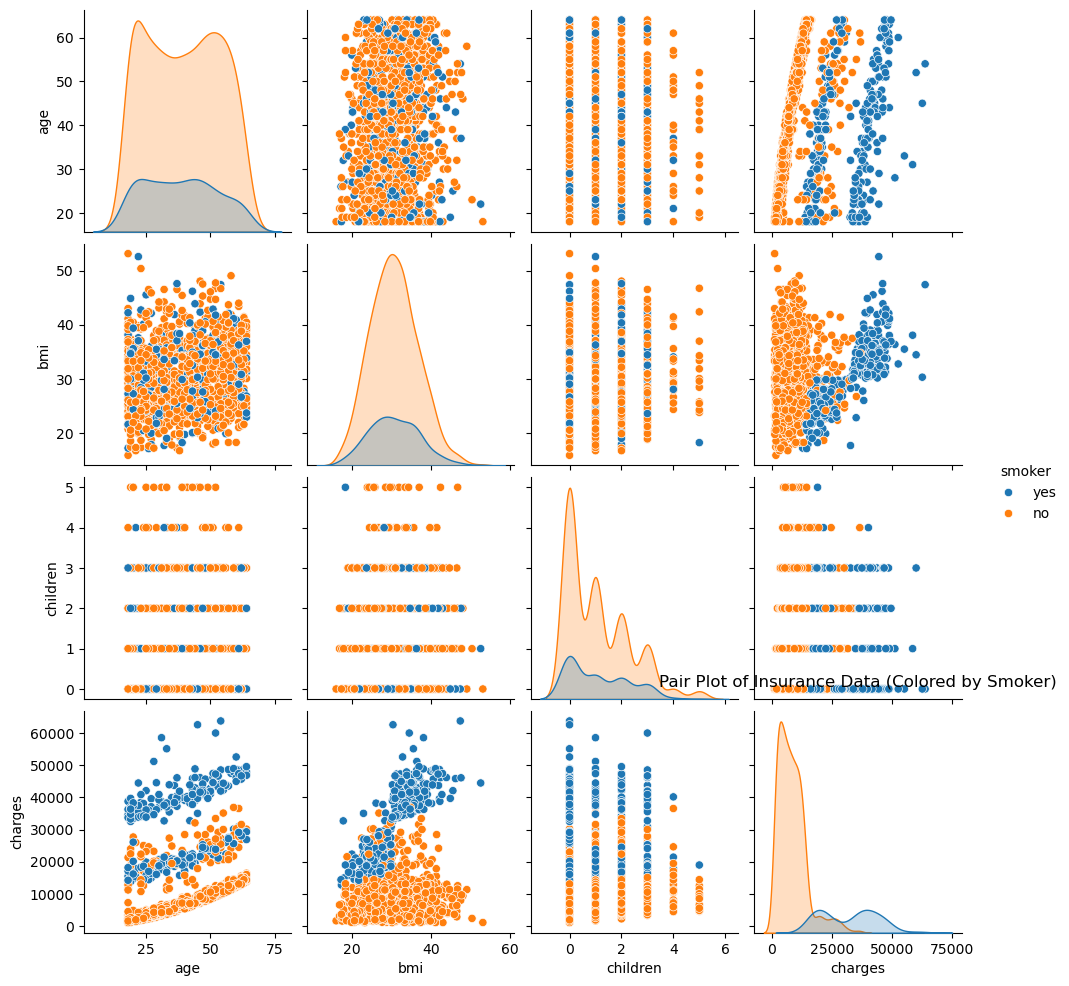

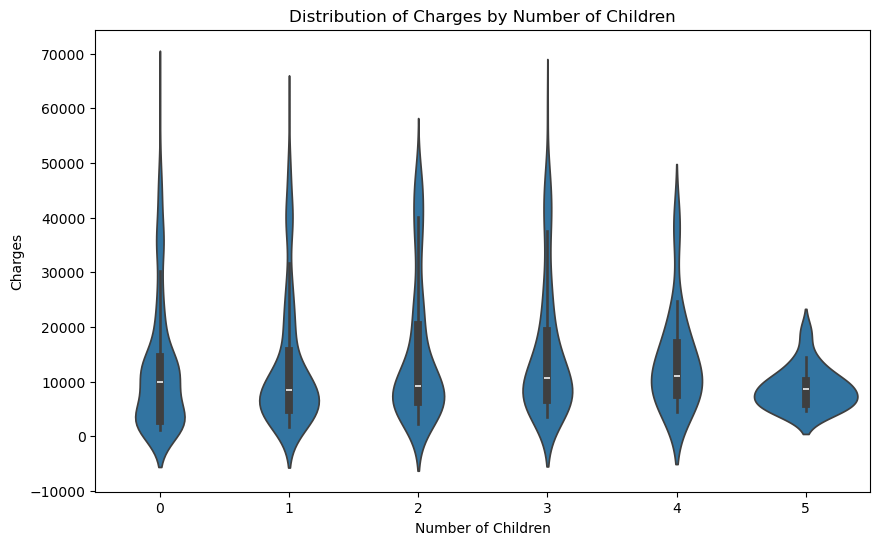

In [7]:
# Code for your answer here!
# Part (a)
# Examine data structure and descriptive statistics
df_insurance.info()
display(df_insurance.describe())

# Check for missing values explicitly
print(df_insurance.isnull().sum())

# Part (b)
# Pair plot colored by 'smoker'
sns.pairplot(df_insurance, hue='smoker')
plt.title("Pair Plot of Insurance Data (Colored by Smoker)")
plt.show()

# Violin plot for 'children' vs 'charges'
plt.figure(figsize=(10, 6))
sns.violinplot(x='children', y='charges', data=df_insurance)
plt.title("Distribution of Charges by Number of Children")
plt.xlabel("Number of Children")
plt.ylabel("Charges")
plt.show()

_For Part (a): Looking at the Dtype column in the .info() output. We see float64 (continuous), int64 (discrete), and object (categorical/strings). Checking the "Non-Null Count" in .info() or the sum from .isnull().sum(). If the count matches the total number of entries, there are no missing values.\
For Part (b): Looking for clear linear patterns (suggesting correlation) or distinct clusters. The hue='smoker' argument show that smokers (one color) generally have significantly higher charges than non-smokers. Violin Plot shows the density of "charges" for each number of children. Look for the width of the "violin" shapes—wider sections mean more data points at that price range._

## Creating a Train-Test Set <a id='gen'></a>

Before modelling, we will first split the data into the train and test sets. This ensures that that we do not violate one of the golden rules of machine learning: never use the test set for training. As EDA can help guide the choice and form of model, we ideally want to split the data before EDA, to avoid peeking at the test data too much during this phase. However, in practice, we may need to investigate the entire data during EDA to get a better idea on how to handle issues such as missingness, categorical data (and rare categories), incorrect data, etc.      

There are lots of ways of creating a test set. We will use a helpful function from `sklearn.model_selection` called `train_test_split`. You can have a look at the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html. Note that `train_test_split` defaults to randomly sampling the data to split it into training and validation/test sets, that is, the default value is `shuffle=True`  

For reproducibility, we first fix the value in the numpy random seed about the state of randomness. This ensures that, every step including randomness, will produce the same output if we re-run the code or if someone else wants to reproduce our results (e.g. produce the same train-test split).

In `sklearn`, the suggestion to control randomness across multiple consecutive executions is as follows: 

- In order to obtain reproducible (i.e. constant) results across multiple program executions, we need to remove all uses of `random_state=None`, which is the default.

- Declare your own `rng` variable (random number generator) at the top of the program, and pass it down to any object that accepts a `random_state` parameter. You can check some details from here; https://numpy.org/doc/1.16/reference/generated/numpy.random.RandomState.html

Thus, our first step before splitting the data is to define our `rng` variable.

In [8]:
# To make this notebook's output identical at every run
rng = np.random.seed(0)
# might be good for our course
# np.random.seed(11205) 

### 🚩 Exercise 2 (CORE)

Run the following code to use `train_test_split()` to split the data randomly into training (70%) and test (30%) sets. The `training set` will contain our training data, called `X_train` and `y_train`. The `test set` will contain our testing data, called `X_test` and `y_test`.

Can you think on a scenario where not shuffling would be a good idea? What about when we do want to shuffle our data?

In [9]:
# As a good practice first split the data
from sklearn.model_selection import train_test_split

X = df_insurance.drop('charges', axis = 1) # Set of features
y = df_insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rng)

_Scenario where NOT shuffling is a good idea: This is crucial for Time Series data (e.g., stock prices, weather data). If our data is ordered by time, we should not shuffle because we want to train on "past" data and test on "future" data. Shuffling would mix the future into the training set, causing "data leakage" and giving we unrealistic performance results.\
When we DO want to shuffle: We shuffle in almost all other cases (like this insurance dataset) to ensure the data is Independent and Identically Distributed (i.i.d.). If the original dataset was sorted (e.g., by age, or by region), taking the first 70% without shuffling would result in a biased training set (e.g., training only on young people and testing only on old people). Shuffling ensures the training and test sets are representative samples of the whole population._

# Least Squares Estimation <a id='RBH'></a>

Consider a linear regression model for `charges` using `bmi` and `smoker` as features in our model. Without sklearn functionalities, let's compute and visualize the least squares estimates.

### 🚩 Exercise 3 (CORE)

Create a scatter plot using `sns.scatterplot` of `charges` vs `bmi`, colored by `smoker`. Describe any apparent relationship between `charges` and `bmi` and comment on the difference between smokers and non-smokers.

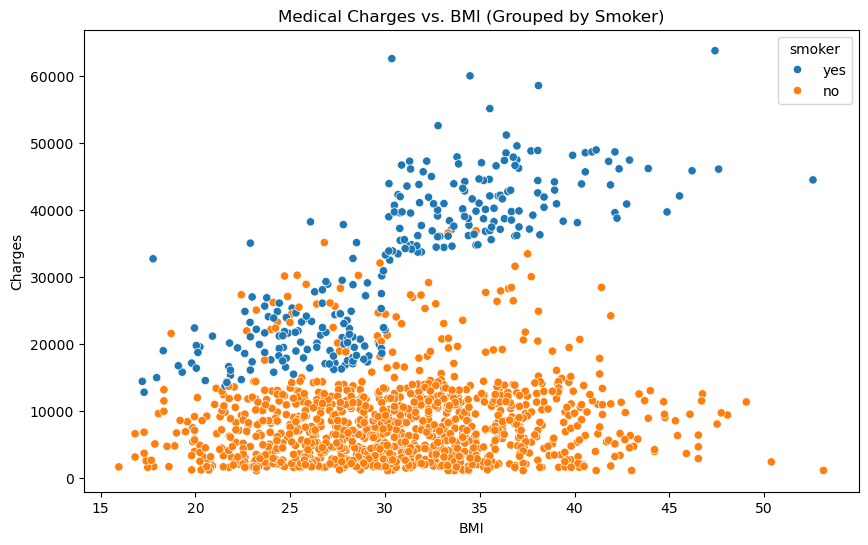

In [10]:
# Code for your answer here!
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_insurance, x='bmi', y='charges', hue='smoker')
plt.title("Medical Charges vs. BMI (Grouped by Smoker)")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

_The "Smoker" Effect: There is a massive separation between the two groups. Smokers are clustered at the top of the chart, meaning they have significantly higher medical charges than non-smokers, regardless of their BMI.\
The Slope Difference:\
Non-smokers: There is a relatively flat or gently rising relationship—higher BMI leads to slightly higher charges, but the increase is gradual.\
Smokers: The relationship is much steeper. As BMI increases for a smoker, their medical charges skyrocket compared to a non-smoker with the same BMI. This suggests an interaction effect between BMI and smoking (i.e., being obese and a smoker is much worse than just the sum of the two individual risks)._

### 🚩 Exercise 4 (CORE)

Now, let's compute the least square estimates.

First let's construct the feature matrix as an `np.array`. Recall that we need to include a column of ones to allow a non-zero intercept. We also need to convert the response `y_train` to an `np.array`.

In [11]:
# Writing the design matrix
X = np.c_[
    np.ones(len(X_train)),
    X_train.bmi,
    X_train.smoker == "yes"
]

# Converting response training object to numpy array
y = np.array(y_train)

X.shape, y.shape

((936, 3), (936,))


a) Next, compute the least squares estimates $\hat{\boldsymbol{w}}$, using the expression from lectures and the `solve` function from `numpy.linalg`.

b) What is the intercept for non-smokers and what is the intercept for smokers?

In [12]:
# Code for your answer here!
# Part (a): Compute the least squares estimates
# Compute X transpose times X (The Gram Matrix)
XTX = X.T @ X
# Compute X transpose times y
XTy = X.T @ y

# We use np.linalg.solve instead of np.linalg.inv for better numerical stability
w_hat = np.linalg.solve(XTX, XTy)

print("Estimated Coefficients (w_hat):", w_hat)
# w_hat[0] is the Bias/Intercept
# w_hat[1] is the coefficient for BMI
# w_hat[2] is the coefficient for Smoker

# Part (b): Calculate intercepts for groups
# The model equation is: charges = w0 + (w1 * bmi) + (w2 * smoker)
intercept_non_smoker = w_hat[0]

intercept_smoker = w_hat[0] + w_hat[2]

print(f"\nIntercept for non-smokers: {intercept_non_smoker:.2f}")
print(f"Intercept for smokers:     {intercept_smoker:.2f}")

Estimated Coefficients (w_hat): [-3385.172326     389.05002587 22926.48168453]

Intercept for non-smokers: -3385.17
Intercept for smokers:     19541.31


### 🚩 Exercise 5 (CORE)

a) Compute the fitted values from this model by calculating $\hat{\mathbf{y}} = \boldsymbol{X} \hat{\boldsymbol{w}}$. 

b) Redraw your scatter plot of `charges`vs `bmi`, colored by `smoker` from Exercise 3, and overlay a line plot of the fitted values (fitted regression line) using `sns.lineplot`. Comment on the results and any potential feature engineering steps that could help to improve the model.  

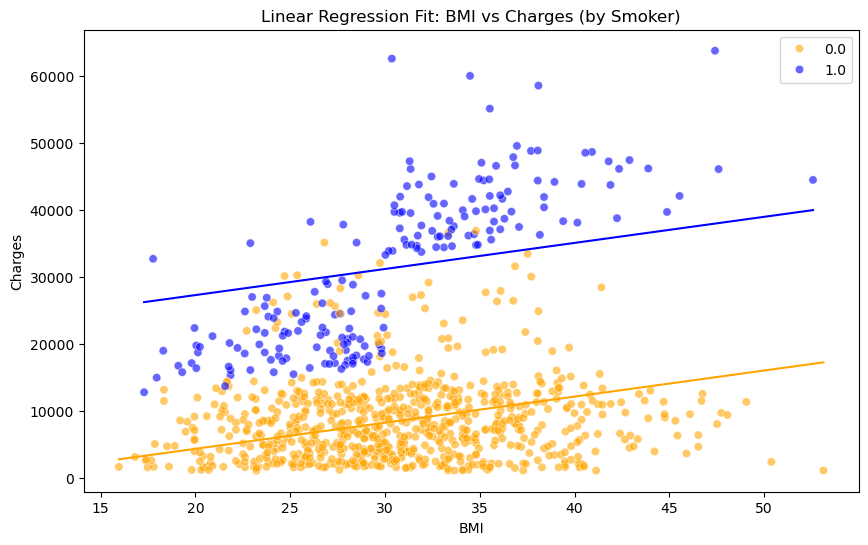

In [16]:
# Code for your answer here
# Part (a): Compute fitted values
# y_hat = X * w_hat
yhat = X @ w_hat

# Part (b): Visualizing the fit
plt.figure(figsize=(10, 6))

# Redraw the scatter plot (Actual Data)
sns.scatterplot(x=X[:, 1], y=y, hue=X[:, 2], palette=['orange', 'blue'], alpha=0.6)

# Overlay the line plot (Fitted Values)
sns.lineplot(x=X[:, 1], y=yhat, hue=X[:, 2], palette=['orange', 'blue'], legend=False)

plt.title("Linear Regression Fit: BMI vs Charges (by Smoker)")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

_The Result: The model produces two parallel lines. This is because our equation $Charges = w_0 + w_1(BMI) + w_2(Smoker)$ forces the slope for BMI ($w_1$) to be the exact same for both groups. The smoker term ($w_2$) only shifts the intercept up.\
The Reality: Looking at the scatter points (the actual data), the slope for smokers is clearly steeper than for non-smokers. Smokers' costs rise much faster with weight gain than non-smokers' do.\
Feature Engineering Step: To fix this, you need to introduce an Interaction Term. You should create a new feature that multiplies BMI by the Smoker status (bmi * smoker). This would allow the model to learn a different slope for smokers, effectively pivoting the blue line to match the steeper data points._

### 🚩 Exercise 6 (EXTRA)

In the following code following code, we compute the standard error for the predictions following the expression in lectures. Add dashed lines to your plot representing the prediction intervals for smokers and non-smokers.

In [17]:
# Compute standard error of predictions
sigmsq = np.sum((y - yhat)**2) / (X.shape[0] - X.shape[1]-1)
sd_err_pred  = np.array([np.sqrt(sigmsq * X[i,:] @ np.linalg.solve(X.T@X, X[i,:].T)) for i in range(X.shape[0])])

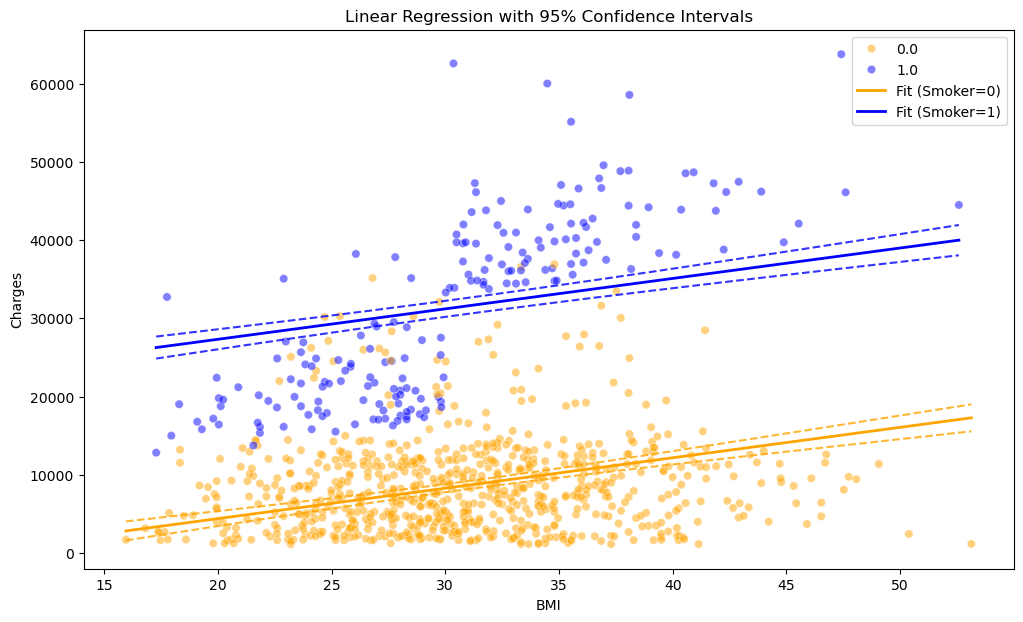

In [19]:
# Code for your answer here!
# 1. Run the provided code to calculate standard errors (from the screenshot)
sigmsq = np.sum((y - yhat)**2) / (X.shape[0] - X.shape[1] - 1)
sd_err_pred = np.array([np.sqrt(sigmsq * X[i,:] @ np.linalg.solve(X.T@X, X[i,:].T)) for i in range(X.shape[0])])

# 2. Calculate the upper and lower bounds (95% interval)
# We use 1.96 as the z-score multiplier for a 95% confidence level
lower_bound = yhat - 1.96 * sd_err_pred
upper_bound = yhat + 1.96 * sd_err_pred

# 3. Plotting
plt.figure(figsize=(12, 7))

# A. Re-draw the scatter plot of actual data
# X[:, 1] is BMI, X[:, 2] is Smoker (0 or 1)
sns.scatterplot(x=X[:, 1], y=y, hue=X[:, 2], palette=['orange', 'blue'], alpha=0.5)

# B. Plot the regression lines and dashed intervals
# We need to define colors manually to match the scatter plot
# 0 (Non-Smoker) -> Orange, 1 (Smoker) -> Blue
groups = {0: 'orange', 1: 'blue'}

for smoker_val, color in groups.items():
    # Create a mask to filter data for this specific group (smoker or non-smoker)
    mask = (X[:, 2] == smoker_val)
    
    # Get the BMI, Fitted Values, and Bounds for this group
    group_bmi = X[mask, 1]
    group_yhat = yhat[mask]
    group_lower = lower_bound[mask]
    group_upper = upper_bound[mask]
    
    # CRITICAL STEP: Sort by BMI so the line connects points in order
    sorted_indices = np.argsort(group_bmi)
    
    # Plot central fitted line (Solid)
    plt.plot(group_bmi[sorted_indices], group_yhat[sorted_indices], 
             color=color, linewidth=2, label=f'Fit (Smoker={smoker_val})')
    
    # Plot prediction intervals (Dashed)
    plt.plot(group_bmi[sorted_indices], group_lower[sorted_indices], 
             color=color, linestyle='--', alpha=0.8)
    plt.plot(group_bmi[sorted_indices], group_upper[sorted_indices], 
             color=color, linestyle='--', alpha=0.8)

plt.title("Linear Regression with 95% Confidence Intervals")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.legend()
plt.show()

## Residuals

A useful tool for evaluating a model is to examine the residuals of that model. For any standard regression model,  the residual for observation $n$ is defined as $y_n - \hat{y}_n$ where $\hat{y}_n$ is the model's fiited value for observation $n$. 

Studying the properties of the residuals is important for assessing the quality of the fitted regression model. This scatterplot (fitted vs residuals) gives us more intuition about the model performance. Briefly, 

>- If the normal linear model assumption is true then the residuals should be randomly scattered around zero with no discernible clustering or pattern with respect to the fitted values. 
>- Furthermore, this plot can be useful to check the constant variance (homoscedastic) assumption to see whether the range of the scatter of points is consistent over the range of fitted values.

### 🚩 Exercise 7 (CORE)

a) Calculate the residuals and create a residual plot (scatter plot of fitted vs residuals) for this model and color by smoker. Comment on quality of the model based on this plot.

b) Compute the $R^2$ value for this model and comment on its value (recall from lectures that $R^2$ is 1 minus the sum of the squared residuals divided by the sum of squared differences between $\mathbf{y}$ and its mean).

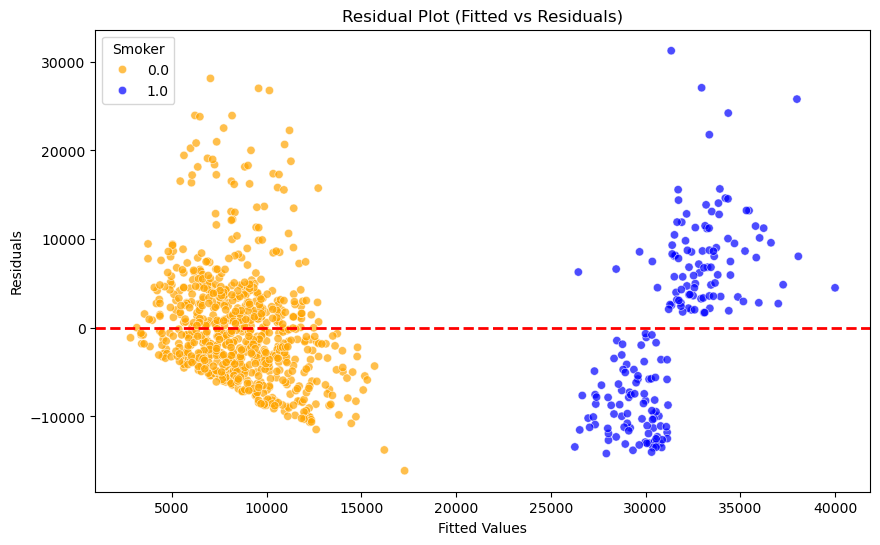

In [ ]:
# Part a: Code for your answer here!

# Calculate residuals
# Residual = Observed (y) - Fitted (y_hat)
residuals = y - yhat

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=yhat, y=residuals, hue=X[:, 2], palette=['orange', 'blue'], alpha=0.7)

# Add a horizontal line at 0 (ideal residuals should be scattered around this)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title("Residual Plot (Fitted vs Residuals)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.legend(title="Smoker")
plt.show()

_We see a distinct pattern (often diagonal lines or clusters) for the "Smoker" group (blue dots). Because we forced the lines to be parallel (same slope for everyone), but the real data for smokers has a much steeper slope, our model fails to capture the trend for smokers correctly. We see that for high fitted values, the residuals drift away from zero. This confirms that the model is misspecified and suggests (again) that we need an interaction term (bmi * smoker)._

In [21]:
# Part b: Code for your answer here!
# Calculate Sum of Squared Residuals (SS_res)
SS_res = np.sum(residuals**2)

# Calculate Total Sum of Squares (SS_tot)
SS_tot = np.sum((y - np.mean(y))**2)

# Calculate R^2
r_squared = 1 - (SS_res / SS_tot)

print(f"R-squared value: {r_squared:.4f}")

R-squared value: 0.6351


_This means our model explains about 63% of the variance in medical charges. While this sounds decent, the residual plot proves we can do better. The remaining 37% of unexplained variance isn't just random noise; a chunk of it is the structural error caused by ignoring the interaction between smoking and BMI._

---
# Regression using scikit-Learn <a id='RSKL'></a>

Linear regression is available in **scikit-learn** (**sklearn**) through `LinearRegression` from the `linear_model` submodule. You can browse through the documentation and examples [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Let's start by importing it.

In [ ]:
from sklearn.linear_model import LinearRegression

In general sklearn's models are implemented by first creating a model object, and then using that object to fit your data. As such, we will now create a linear regression model object `lr` and use it to fit our data. Once this object is created we use the `fit` method to obtain a model object fitted to our data. 

_Note:_ by default an intercept is included in the model. So, we do NOT need to add a column of ones to our design matrix.

_Note:_ in the code below we use `make_column_transformer` which automatically names all of our transformers. To see the names, run `preprocessor.named_transformers_`. You can then access each transformer by its name, if you want to view it's attributes or call methods on it, e.g. `preprocessor['onehotencoder'].get_feature_names_out()`.

_Note:_ using the option `OneHotEncoder(drop=np.array(['Reference Category']))`, we can specify the which category to drop (the reference category) by replacing `'Reference Category'` with the desired category.

In [ ]:
lr = LinearRegression()

# Create feature matrix
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
preprocessor = make_column_transformer(
    (OneHotEncoder(drop=np.array(['no'])), ['smoker']), # encode 'smoker' column
    (StandardScaler(), ['bmi']), # scale 'bmi' column
    remainder='drop', # drop everthing else
    verbose_feature_names_out=False)
X_train_ = preprocessor.fit_transform(X_train)

lr_fit = lr.fit(
    X = X_train_, 
    y = y_train
)

# To see the names of the transformers
# preprocessor.named_transformers_
# You can call a method or access attributes of each transformer by its name
# preprocessor['onehotencoder'].get_feature_names_out()

This model object then has various useful methods and attributes, including `intercept_` and `coef_` which contain our estimates for $\boldsymbol{w}$. 

_Note:_ if `fit_intercept=False` and a column of ones is included in the design matrix, then both the intercept and coefficient will be stored in `coef_`.

In [ ]:
w_0 = lr_fit.intercept_  # Intercept term of the fitted model
w_1 = lr_fit.coef_ 

w = np.concatenate([[w_0], w_1])
feature_names = ['intercept'] + list(preprocessor.get_feature_names_out())  
w_df = pd.DataFrame({'feature': feature_names, 'coefficient': w})
w_df

Importantly, to avoid _data leakage_ and improve _reproducibility_, we should always be combining our feature enginnering and model fitting steps into a single **pipeline**. 

_Note:_ in the code below we use `make_pipeline` which automatically names all of our transformers/estimators. To see the names, run `preprocessor.named_steps`. You can then access each step by its name or its index in the pipeline, e.g. `pipe['columntransformer'].get_feature_names_out()`.

In [ ]:
# Combine into pipeline
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(
    preprocessor,
    LinearRegression()
)

pipe_fit = pipe.fit(
    X = X_train,
    y = y_train
)

# You can access the coefficients by the index of the final step
pipe[-1].coef_ 
# Or by its name
# pipe.named_steps
# pipe['linearregression'].coef_

The model fit objects also provides additional useful methods for evaluating the model $R^2$ (`score`) and calculating predictions (`predict`). Let's use the latter to compute the fitted values and predictions, as well as some metrics to evaluate the performance on the test data.

In [ ]:
# Fitted values
y_fit = pipe.predict(X_train)

# Predicted values
y_pred = pipe.predict(X_test)

# The mean squared error of the training set 
print("Training Mean squared error: %.3f" % mean_squared_error(y_train, y_fit))
# The R squared of the training set 
print("Training R squared: %.3f" % r2_score(y_train, y_fit))

# The mean squared error of the test set 
print("Test Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
# The R squared of the test set 
print("Test R squared: %.3f" % r2_score(y_test, y_pred))

# Another way for R2 calculation
print(pipe.score(X_train, y_train)) 

Or we can use our helper function and also plot the fitted values and residuals to identify if there are potential patterns.

In [ ]:
# If we use the pre-defined function
model_fit(pipe, X_train, y_train, plot = True)

Lastly, we can use our helper function to compute standard errors of the coefficients and plot them.

In [ ]:
sd, cov_mat = compute_std_error(pipe, X_train, y_train, plot=True, feature_names=['smoker_yes', 'bmi'])

### 🚩 Exercise 8 (CORE)

Next, modify your pipeline to also include `age` as feature.

Fit the model on the training data and calculate performance metrics similar to above ($R^2$, and MSE / RMSE). How does this model compare to previous one?

In [ ]:
# Code for your answer here!

_Type your answer here_

--------

# Polynomial Regression<a id='polyreg'></a>


## Polynomial features in sklearn

sklearn has a built in function called `PolynomialFeatures` which can be used to simplify the process of including polynomial features in a model. You can browse the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). This function is included in the *preprocessing* module of sklearn, as with other python functions we can import it as follows.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

Construction and use of this is similar to what we have already seen with other transformers; we construct a PolynomialFeatures object in which we set basic options (e.g. the degree of the polynomial) and then apply the transformation to our data by calling `fit_transform`. This will generate a new model matrix which includes the polynomial features up to the degree we have specified.

Run the following code for a simple illustration:

In [ ]:
x = np.array([1, 2, 3, 4])
PolynomialFeatures(degree = 2).fit_transform(x.reshape(-1,1))

Note that when we use this transformation, we get **all of the polynomial transformations of x from 0 to degree**. 

In this case, the **0 degree column** is equivalent to **the intercept column**. If we do not want to include this we can construct `PolynomialFeatures` with the option `include_bias=False`.

In [ ]:
PolynomialFeatures(degree = 2, include_bias=False).fit_transform(x.reshape(-1,1))

We can also use `PolynomialFeatures` to add only interaction terms, through the option `interaction_only=True`. As an illustration run the following code:

In [ ]:
x = np.array([[1, 2, 3, 4],[0,0,1,1]]).T
PolynomialFeatures(interaction_only=True,include_bias=False).fit_transform(x)

## Interactions

Now, let's create a pipeline that:

- includes `bmi` as a numerical variable and smoker condition as a categorical variable

- applies encoding for the `smoker` variable

- uses `PolynomialFeatures` to include an **interaction** between `smoker` and `bmi`

In [ ]:
# Create Pipeline for model that includes interactions
preprocessor = make_column_transformer(
    (OneHotEncoder(drop=np.array(['no'])), ['smoker']), # encode 'smoker' column
    (StandardScaler(), ['bmi']), # scale 'bmi' column
    verbose_feature_names_out=False)

# Create and fit new pipeline
pipe3 = make_pipeline(
    preprocessor,
    PolynomialFeatures(interaction_only=True,include_bias=False), # add extra step for interaction terms
    LinearRegression()
).fit(X_train, y_train)

_Note:_ we set `include_bias=False` as the intercept is included in linear regression by default.

We can also extract the **names of the features** using the method `get_feature_names_out()`. 

In [ ]:
# Names after the first transformer
print(pipe3[0].get_feature_names_out())

# Names after the first transformer and interaction step
print(pipe3[:-1].get_feature_names_out())

# Create a data frame to see the intercept and coefficients
w = [pipe3[-1].intercept_] + pipe3[-1].coef_.tolist() 
feature_names = ['intercept'] + list(pipe3[:-1].get_feature_names_out())  
w_df = pd.DataFrame({'feature': feature_names, 'coefficient': w})
w_df

### 🚩 Exercise 9 (CORE)

For the model trained above (`pipe3`):

a) What is the intercept and slope for non-smokers and what is the intercept and slope for smokers?

b) Compute the fitted values by calling `predict`. Draw the scatter plot of bmi against charges, colored by smoker (from Exercise 3), and overlay a line plot of the fitted values (fitted regression lines).

c) How does this model compare to our previous models `pipe` and `pipe2`?

In [ ]:
# Code for your answer here 

_Type your answer here_

## Nonlinearity

Now, let's explore including nonlinearity into the model through a polynomial basis function expansions of `bmi`.

### 🚩 Exercise 10 (CORE)

First, suppose you naively apply a polynomial basis function expansion to the feature matrix containing `bmi` and `smoker`: 

- Run the code below to create the transformed feature matrix using `PolynomialFeatures` assuming `degree=2`. 

- Why should we **NOT** use this naive polynomial basis function expansion?

In [ ]:
# Create a transformed feature matrix containing a polynomial expansion (degree 2) of bmi and smoker 

# Create Pipeline for model that includes interactions
preprocessor = make_column_transformer(
    (OneHotEncoder(drop=np.array(['no'])), ['smoker']), # encode 'smoker' column
    (StandardScaler(), ['bmi']), # pass through 'bmi' column
    verbose_feature_names_out=False)

# Create and fit new pipeline
fe = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=2), # add step for polynomial features
)

Xt = fe.fit_transform(X_train)
Xt_ = pd.DataFrame(Xt, columns=fe.get_feature_names_out())
Xt_.head()

_Type your answer here_


### 🚩 Exercise 11 (CORE)

Now, let's create a model that allows nonlinearity of `bmi` through polynomial basis function expansion of degree 3 (with no interactions for ease of exposition). 

Create a new pipeline to construct this model. Train this model and then plot the fitted regression line and compute the performance metrics.

In [ ]:
# Code for your answer here

## Choosing the Order of the Polynomial

How can we choose the order of the polynomial? 

In lecture, we discussed how chosing the degree to be too large can cause over fittting. When we over fit a polynomial regression model, the MSE for the training data will appear to be low which might indicate that the model is a good fit. But, as a result of over fitting, the MSE for the predictions of the unseen test data may begin to increase. However, we can **NOT** use the test to determine the order of the polynomial, so in the following, we explore using cross-validation to do so.

### Tunning with GridSearchCV

If we wish to test over a specific set of parameter values using cross validation we can use the `GridSearchCV` function from the `model_selection` submodule. In this setting, the hyperparamer is actually the degree of the polynomial that we are investigating. 

This argument is a dictionary containing parameters names as keys and lists of parameter settings to try as values. Since we are using a pipeline, our parameter name will be the name of the pipeline step, `columntransformer`, followed by `__`, (then, the name of next step if applicable, e.g. `pipeline__` since we are using `Pipeline` for the steps of the numerical features, and `polynomialfeatures__` for the polynomial expansion) , and then the parameter name, `degree`. So for our pipeline the parameter is named `columntransformer__pipeline__polynomialfeatures__degree`. If you want to list the names of all available parameters you can call the `get_params()` method on the model object, e.g. `polyreg_pipe.get_params()` here.

In [ ]:
# Create Pipeline for model that includes polynomial expansions of bmi
num_pre = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(include_bias=False)
)

preprocessor = make_column_transformer(
    (OneHotEncoder(drop=np.array(['no'])), ['smoker']), # encode 'smoker' column
    (num_pre, ['bmi']), # polynomial features of 'bmi' column
    verbose_feature_names_out=False)

# Create the new pipeline
polyreg_pipe = make_pipeline(
    preprocessor,
    LinearRegression(), # add step for polynomial features
)

# To see the names of the parameters that can be tuned
# polyreg_pipe.get_params() #names of all parameters
# polyreg_pipe['columntransformer'].get_params()  #names of parameters for the preprocessor

In [ ]:
# Define parameter grid for degree of polynomial features
parameters = {
    'columntransformer__pipeline__polynomialfeatures__degree': np.arange(1,10,1)
}

# Define cross-validation scheme
kf = KFold(n_splits = 5, shuffle = True, random_state=rng)

# Grid search with cross-validation
grid_search = GridSearchCV(polyreg_pipe, parameters, cv = kf, 
                           scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train, y_train)

The above code goes through the process of fitting all $5 \times 9$ models as well as storing and ranking the results for the requested scoring metric(s). Note that here we have used `neg_mean_squared_error` as our scoring metric which returns the **negative of the mean squared error**. For more on metrics of regression models, please see: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

- As the name implies this returns the negative of the usual fit metric, this is because sklearn expects to always optimize for the maximum of a score and the model with the largest negative MSE will therefore be the "best". 

- In this workshop we have used MSE as a metric for testing our models. This metric is entirely equivalent to the root mean squared error for purposes of ranking / ordering models (as the square root is a monotonic transformation). 
- Sometimes the RMSE is prefered as it is more interpretable, because it has the same units as $y$.

Once all of the submodels are fit, we can determine the optimal hyperparameter value by accessing the object's `best_*` attributes,

In [ ]:
print("best index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

The best estimator is stored in the `.best_estimator` attribute. By default, after this model is found, it is retrained on all training data points.

In [ ]:
grid_search.best_estimator_[-1].coef_

In [ ]:
# Extract the names of the features and coefficients
w = [grid_search.best_estimator_[-1].intercept_] + grid_search.best_estimator_[-1].coef_.tolist() 
feature_names = ['intercept'] + list(grid_search.best_estimator_[:-1].get_feature_names_out())  
w_df = pd.DataFrame({'feature': feature_names, 'coefficient': w})
w_df

In [ ]:
# Compute fitted values
yhat =grid_search.predict(X_train)

# Plot fitted values
ax = sns.scatterplot(x = X_train.bmi, y = y_train, hue = X_train.smoker)
sns.lineplot(x = X_train.bmi, y = yhat, hue = X_train.smoker, ax=ax, legend = False)
ax.set(ylabel='charges')
plt.show()

The cross-validated scores are stored in the attribute `cv_results_`. This contains a number of results related to the grid search and cross-validation. We can convert it into a pandas data frame to view the results.

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

It is also recommend to plot the CV scores. Although the grid search may report a best value for the parameter corresponding to the maximum CV score (e.g. min CV MSE), if the curve is relatively flat around the minimum, we may prefer the simpler model.

Note in this case, I have also used the option `return_train_score=True` in `GridSearchCV()`, in order to save also the training scores. As expected training MSE decreases when increasing the degree of the polynomial, but the CV MSE has more of a U-shape.

In [ ]:
degree = np.arange(1,10,1)
fig, ax = plt.subplots(1,1,figsize=(6,4))
plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='k')
plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='k', label='Mean Train MSE')
plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='r')
plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='r', label='CV MSE')
ax.legend()
ax.set_xlabel('degree')
ax.set_ylabel('MSE')
plt.show()

### 🚩 Exercise 12 (CORE)

Based on the plot above, would you use the best estimator or choose a different degree? Why?

Try changing `random_state` in the grid search to different value. Does the best estimator still choose the same degree?

_Type your answer here_

### 🚩 Exercise 13 (EXTRA)

Try an alternative model of your choice. What have you chosen and why? Are there any parameters to tune?

In [ ]:
# Code for your answer here


_Type your answere here_

### Further resources

- About common pitfalls and interpreting coefficients: 

https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please **change 'Student 1' and 'Student 2' at the top of the notebook to include your name(s)**.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF. 

In [ ]:
!jupyter nbconvert --to pdf mlp_week04_key.ipynb 